
# Project: Wrangle and Analyze Data - [twitter_archive from @dog_rates](https://twitter.com/dog_rates)

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#insight">Insights</a></li>
<li><a href="#visual">Visualization</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

**Dog table:**
- name: name of dog
- rating out of 10
- stage (age): doggo, puppo, pupper in DESC order
- floofer: dogs with excess fur
- predictions (3 predictions): breed, confidence in prediction, and if prediction is a dog breed


**Tweet table:**
- timestamp: date of the tweet
- text: text content of the tweet
- expanded_url: link to the tweet
- retweet_count: number of retweets
- favorite_count: number of favorites

##### Content


**We have assembled this data from multiple sources and had to clean where we could.**  

We have kept data that we can analyze and that we have correspending data from the other tables.
And have reached a point where we can confidently use the 3 datasets we merged together for analysis.


We want to look at a dataset with tweets and dog tables. We will use these to find out if there is a particular breed, name, stage that stands out. What the relationship might be between twitter metrics for performance and dogs.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
dog_df = pd.read_csv('data/dogs_master.csv')
tweet_df = pd.read_csv('data/tweet_master.csv')

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [9]:
tweet_df.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'expanded_urls', 'retweet_count', 'favorite_count',
       'jpg_url'],
      dtype='object')

In [4]:
dog_cols = ['tweet_id',  'rating_numerator', 'rating_denominator', 'name', 'floofer', 'dog_stage','breed_prediction_1', 'confidence_1',
       'is_dog_1', 'breed_prediction_2', 'confidence_2', 'is_dog_2','breed_prediction_3', 'confidence_3', 'is_dog_3']
tweet_cols = ['tweet_id','retweet_count', 'favorite_count']

In [5]:
data = pd.merge(tweet_df[tweet_cols], dog_df[dog_cols], on=['tweet_id'], how='left')

In [6]:
data.head(2)

,tweet_id,retweet_count,favorite_count,rating_numerator,rating_denominator,name,floofer,dog_stage,breed_prediction_1,confidence_1,is_dog_1,breed_prediction_2,confidence_2,is_dog_2,breed_prediction_3,confidence_3,is_dog_3
0,892420643555336193,8853,39467,13,10,Phineas,False,NaN,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,6514,33819,13,10,Tilly,False,NaN,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [7]:
rating_by_stage = data.groupby('dog_stage')[['retweet_count', 'favorite_count', 'rating_numerator']].agg(['mean']).sort_values(by=[('rating_numerator', 'mean')])

In [8]:
rating_by_stage.apply(lambda x: round(x,2))

,retweet_count,favorite_count,rating_numerator
,mean,mean,mean
dog_stage,,,
pupper,2463.95,7212.02,10.79
doggo,6310.42,17366.46,11.84
puppo,6847.04,21871.08,12.08


In [9]:
pd.pivot_table(data, values=['retweet_count', 'favorite_count', 'rating_numerator'], index=['floofer'], aggfunc=['count','mean'])

count                                          mean  \
        favorite_count rating_numerator retweet_count favorite_count   
floofer                                                                
False             2097             2097          2097    8882.920839   
True                10               10            10   11674.900000   

                                        
        rating_numerator retweet_count  
floofer                                 
False          10.815451   2788.405818  
True           11.800000   4083.600000

Ratio between retweets and favorites.

In [197]:
(data.favorite_count/data.retweet_count).median()

3.1923454367026496

In [25]:
data[['confidence_1', 'confidence_2', 'confidence_3']].mean()

confidence_1    0.595683
confidence_2    0.135034
confidence_3    0.060167
dtype: float64

We look at breeds that are predicted to be dog breeds by the neural network.

In [10]:
is_dog = data.query("is_dog_1 == True")

In [11]:
dog_breed = data.breed_prediction_1.value_counts()

In [12]:
dog_breed = dog_breed.to_frame().reset_index().rename(columns={'index': 'breed_prediction_1', 'breed_prediction_1': 'count'})

In [13]:
is_dog = pd.merge(is_dog, dog_breed, on=['breed_prediction_1'], how='left')

In [14]:
mean_dog_df = is_dog.groupby('breed_prediction_1')[['retweet_count', 'favorite_count', 'rating_numerator', 'count']].agg('mean').reset_index().sort_values(by=['rating_numerator'])

In [15]:
top_names = is_dog.name.value_counts().head(10).index
top_breeds = dog_breed.head(10).breed_prediction_1.values

In [16]:
top_breeds_df = data[data['breed_prediction_1'].apply(lambda x: x in top_breeds)]
top_names_df = data[data['name'].apply(lambda x: x in top_names)]

In [17]:
dog_breed.head(10)

,breed_prediction_1,count
0,golden_retriever,137
1,Labrador_retriever,95
2,Pembroke,87
3,Chihuahua,78
4,pug,53
5,chow,41
6,Samoyed,40
7,toy_poodle,38
8,Pomeranian,37
9,malamute,29


In [18]:
is_dog.name.value_counts().head(10)

Cooper     10
Charlie    10
Oliver      9
Lucy        8
Tucker      8
Penny       7
Daisy       7
Sadie       7
the         6
Winston     6
Name: name, dtype: int64

In [19]:
top5_breeds = mean_dog_df.sort_values(by=['count'], ascending=False).head(5)

In [20]:
top5_breeds_df = is_dog[is_dog.breed_prediction_1.apply(lambda x: x in top_breeds[:5])]

In [21]:
top5_breeds

,breed_prediction_1,retweet_count,favorite_count,rating_numerator,count
86,golden_retriever,3585.554745,12190.160584,11.554745,137.0
35,Labrador_retriever,3859.810526,11830.000000,11.126316,95.0
47,Pembroke,3207.482759,11372.517241,11.528736,87.0
15,Chihuahua,2822.179487,8645.205128,10.807692,78.0
98,pug,1864.641509,6028.245283,10.377358,53.0


<a id='insight'></a>
### Insights:
1. There is a strong relationship between ratings and performance. Tweets tend to get about 3 times more favorites than retweets. 

2. Japanese spaniel has the lowest rating at 5, with afghan hound having thenhighest at 13.

3. Golden retrievers are by far the most common at 137 in the first prediction followed by Labrador retriever with 95 in second place.

4. Cooper and Charlie are most common names with 10 each, followed by Oliver at 9, Lucy and Tucker complete the top 5 at 8 each.

<a id='visual'></a>
### Visualization

#### Top breeds:

- Pugs and Chihuahuas rate lowest at 10.38 and 10.81.
- Golden Retrievers are rated 11.55 with on average 12 190 favorites.
- Labrador Retrievers are rated third behind Pembroke, but receive more retweets and favorites as they are more popular with people than those who are giving the ratings.

In [ ]:
sns.set(rc={"figure.figsize":(12, 8)})

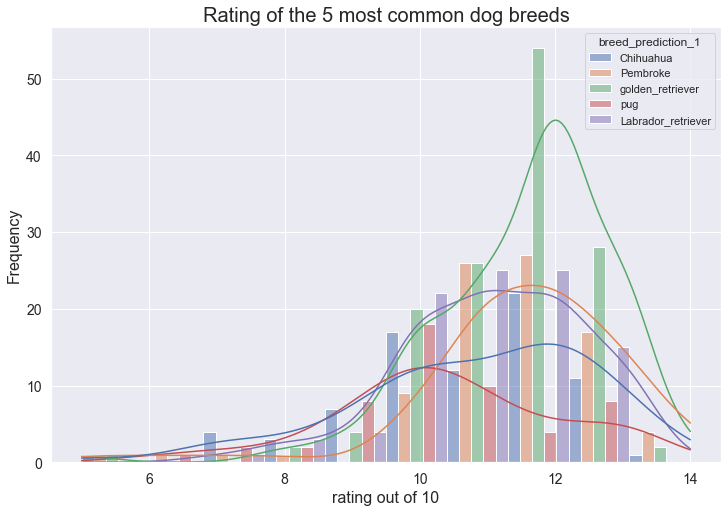

In [124]:
sns.histplot(data=top5_breeds_df, x="rating_numerator", hue="breed_prediction_1", multiple="dodge", bins=10,  shrink=1, kde=True);
plt.title('Rating of the 5 most common dog breeds', fontsize=20);
plt.xlabel("rating out of 10", fontsize=16);
plt.ylabel("Frequency", fontsize=16);
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

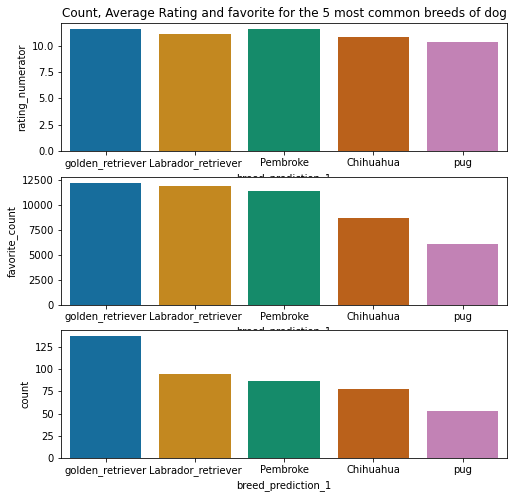

In [40]:
fig, ax = plt.subplots(nrows=3, figsize = [8,8])
sns.barplot(x="breed_prediction_1", y="rating_numerator", data=top5_breeds, ax=ax[0], palette="colorblind").set(title='Count, Average Rating and favorite for the 5 most common breeds of dog');
sns.barplot(x="breed_prediction_1", y="favorite_count", data=top5_breeds, ax=ax[1], palette="colorblind");
sns.barplot(x="breed_prediction_1", y="count", data=top5_breeds, ax=ax[2], palette="colorblind");

#### Rating by stage

- Puppo has the highest ratings and performance, closely followed by doggo and last is pupper with a lot lower performance and on average 1 rating below the others.

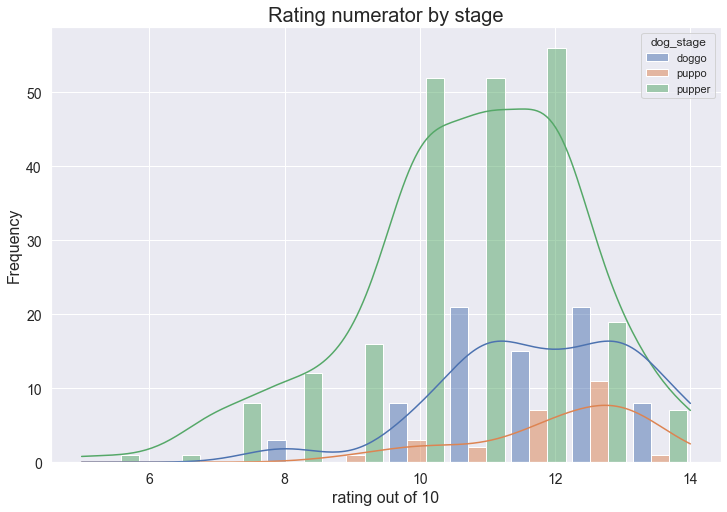

In [132]:
sns.histplot(data=data, x="rating_numerator", hue="dog_stage", multiple="dodge", bins=10,  shrink=.9, kde=True)
plt.title('Rating numerator by stage', fontsize=20);
plt.xlabel("rating out of 10", fontsize=16);
plt.ylabel("Frequency", fontsize=16);
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

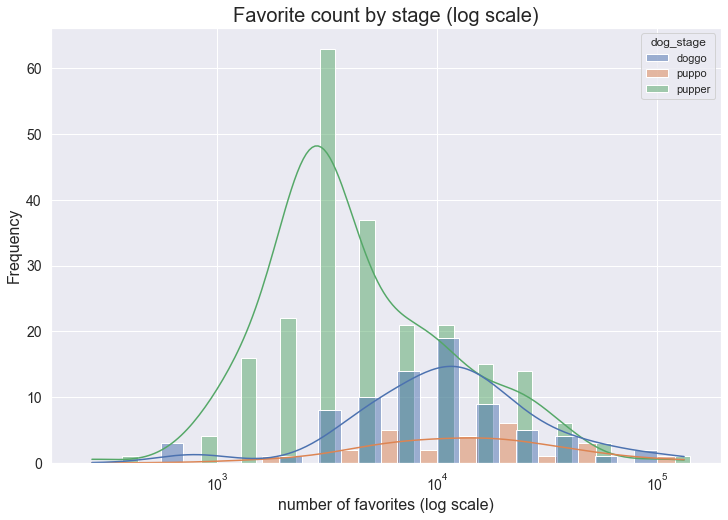

In [133]:
sns.histplot(data=data, x="favorite_count", hue='dog_stage', multiple="dodge", bins=15, log_scale=True, kde=True, shrink=1.4)
plt.title('Favorite count by stage (log scale)', fontsize=20);
plt.xlabel("number of favorites (log scale)", fontsize=16);
plt.ylabel("Frequency", fontsize=16);
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

#### Rating vs frequency
- There doesn't seem to be any indication that people post the breeds that get high ratings most.
- Based on the number of tweets with lower rated breeds, it could just be that those are the most commonly owned dog breeds.

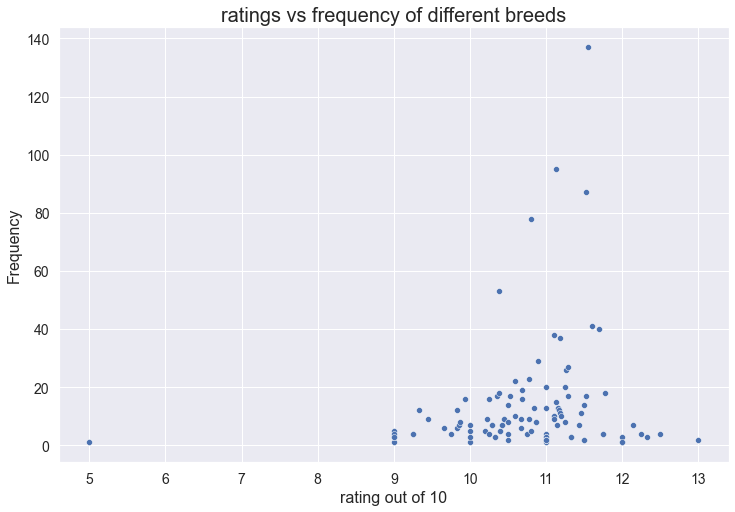

In [151]:
sns.scatterplot(data=mean_dog_df, x="rating_numerator", y="count");
plt.title('ratings vs frequency of different breeds', fontsize=20);
plt.xlabel("rating out of 10", fontsize=16);
plt.ylabel("Frequency", fontsize=16);
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);